In [43]:
import numpy as np
import Backgammon as B
import agent as A
import flipped_agent as FA
import tensorflow as tf
import keras
import keras.layers as L
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy

In [25]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], []
        boards = np.vstack(boards)
        return moves, boards
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        out_board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return out_board, reward, self.done
    
    def symbolic_step(self, move):
        board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                board = B.update_board(board = board, move = m, player = 1)
        reward = 0
        done = False
        if B.game_over(board):
            reward = 1
            done = True
        return board, reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [69]:
class Agent:
    def __init__(self, gamma = 0.99):
        
        self._gamma = 0.99
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.actor = keras.models.Sequential()
        self.actor.add(L.Dense(32))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(64))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(32))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(1))
        
        # Critic
        
        self.critic = keras.models.Sequential()
        self.critic.add(L.Dense(32))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(64))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(32))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(1))
        
        # Losses and logits
        
        ## Critic
        self._state_values = self.critic(self._states)
        self._afterstate_values = self.critic(self._afterstates) * (1 - self._done)
        self._advantage = self._cumulative_rewards + self._gamma * self._afterstate_values - self._state_values
        
    
        self._target_state_values = self._cumulative_rewards + self._gamma * self._afterstate_values * (1 - self._done)
        
        self._critic_loss = tf.reduce_mean((self._state_values - tf.stop_gradient(self._target_state_values)))
        self._critic_optimizer = tf.train.AdamOptimizer()
        self._critic_update = self._critic_optimizer.minimize(self._critic_loss)
        
        ## Actor
        self._actor_logits = self.actor(self._states)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        
        self._actor_loss = -tf.reduce_sum(self._actor_log_policy * tf.stop_gradient(self._advantage))
        self._actor_optimizer = tf.train.AdamOptimizer()
        self._actor_update = self._actor_optimizer.minimize(self._actor_loss)
        
        self._s = tf.InteractiveSession()
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        
        return np.random.choice(np.arange(len(probs)), p = probs)
    
    def update(self, boards, rewards, afterstates, done):
        self._s.run([self._actor_update, self._critic_update], 
                    ({self._states: boards, 
                      self._afterstates: afterstates,
                      self._done: done,
                      self._cumulative_rewards: rewards}))
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R

Win percentage:  0.87


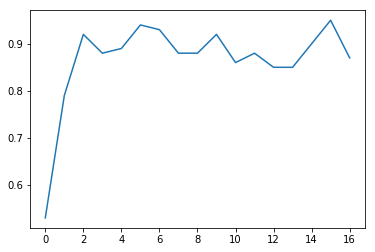

KeyboardInterrupt: 

In [74]:
player = Agent()

win_pct = []

for i in range(1000):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        rewards = []
        boards = []
        afterstates = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = player.sample_action(possible_boards)
                old_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                boards.append(old_board)
                afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                
                for _ in range(1 + int(dice[0] == dice[1])):
                        old_state, reward, done = env.make_move(dice)
                        if done:
                            rewards[-1] = -1
                            break
                            
        afterstates.append(old_board)
        afterstates = afterstates[2:]
        Dones = np.zeros(len(boards))
        Dones[-1] = 1
        Boards = np.vstack(boards)
        Rewards = player.get_cumulative_rewards(rewards)
        AfterStates = np.vstack(afterstates)
        player.update(boards = Boards, rewards = Rewards, afterstates = AfterStates, done = Dones)
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    